# Academy Awards Analysis 🎬
## Investigating Trends in Oscar-Winning Movies
### Author: Judd Jacobs

This project analyzes historical **Academy Award-winning films** using data from **Wikipedia**, **The Movie Database (TMDb)**, and **The Open Movie Database (OMDb)**.

## **Key Analysis Areas**
- **Best Picture trends by genre** (from Wikipedia Scrape & TMDb API) 🏆
- **Box office revenue & IMDb ratings** (OMDb API) 🎭
- **Long-term trends in Oscar-winning films** 📈

## **Step 1:** Import necessary Python Libraries 💽

In [7]:
import pandas as pd
import numpy as np
import requests
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from dotenv import load_dotenv
import os
from urllib.parse import quote
import time
import re
import json

# # Import NLTK libraries are currently a strech goal for future development
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # Ensure necessary NLTK components are downloaded
# nltk.download("stopwords")
# nltk.download("punkt")

## **Step 2:** Data Acquisition 🗂

### **Scrape** Wikipedia
Extract **Best Picture winners**, nominees, and relevant metadata availble on Wikipedia here: https://en.wikipedia.org/wiki/List_of_Academy_Award–winning_films
- **`pandas.read_html()`** to extract the table structure.
- **`BeautifulSoup`** to identify "winning" rows based on Wikipedia background color.

In [2]:
# Wikipedia URL for Best Picture winners
wiki_url = "https://en.wikipedia.org/wiki/List_of_Academy_Award%E2%80%93winning_films"

# Use pandas to extract the table
tables = pd.read_html(wiki_url)

# Select the correct table, adjusting the index as needed
best_picture_wikipedia = tables[0]

# # Convert the table to a DataFrame - I may be able to remove this step
# best_picture_wikipedia = pd.DataFrame(best_picture_wikipedia)

# Print the first few rows to ensure the correct table was selected
print(best_picture_wikipedia.head())
print(best_picture_wikipedia.dtypes)

             Film  Year Awards Nominations
0           Anora  2024      5           6
1   The Brutalist  2024      3          10
2    Emilia Pérez  2024      2          13
3          Wicked  2024      2          10
4  Dune: Part Two  2024      2           5
Film           object
Year           object
Awards         object
Nominations    object
dtype: object


In [3]:
# Find the Wikipedia table with BeautifulSoup
response_wikipedia = requests.get(wiki_url)
soup_wikipedia = BeautifulSoup(response_wikipedia.text, "html.parser")
wikipedia_table = soup_wikipedia.find_all("table", {"class": "wikitable"})[0]

# Extract all rows
rows = wikipedia_table.find_all("tr")

# List to store "Winner" status
winning_status = []

# Loop through rows and check for background color "#EEDD82" skipping the header row
for row in rows[1:]:
    style = row.get("style", "")
    
    # Check if the row has the background color for winners and remove spaces for consistency
    if "background:#EEDD82" in style.replace(" ", ""):
        winning_status.append("Winner")
    else:
        winning_status.append("Nominee")

# Ensure the list length matches the DataFrame
if len(winning_status) == len(best_picture_wikipedia):
    best_picture_wikipedia["Status"] = winning_status
else:
    print("List length does not match DataFrame length")

# # Normalize "Status" column and filter only winners
# best_picture_winners = best_picture_wikipedia[best_picture_wikipedia["Status"] == "Winner"]

# # Convert the table to a DataFrame
# best_picture_wikipedia = pd.DataFrame(best_picture_wikipedia)

# Display updated DataFrame
print(best_picture_wikipedia.head())
print(best_picture_wikipedia.dtypes)

             Film  Year Awards Nominations   Status
0           Anora  2024      5           6   Winner
1   The Brutalist  2024      3          10  Nominee
2    Emilia Pérez  2024      2          13  Nominee
3          Wicked  2024      2          10  Nominee
4  Dune: Part Two  2024      2           5  Nominee
Film           object
Year           object
Awards         object
Nominations    object
Status         object
dtype: object


### Fetch Genres from TMDb API 🎭
Use **The Movie Database (TMDb) API** to retrieve **movie genres** for Best Picture winners listed in Wikipedia Dataset.

⚠️ Note: the cell below may take up to two minutes, or longer, to load. ⚠️

In [4]:
# Load environment variables from .env file
load_dotenv()

# Access the TMDB API keys stored in the .env file and define them here
tmdb_api_key = os.getenv('TMDB_API_KEY')
tmdb_api_read_access_token = os.getenv('TMBD_API_READ_ACCESS_TOKEN')

tmdb_api_base_url = "https://api.themoviedb.org/3"

# Function to get genre mappings (ID -> Name)
def get_genre_mapping() -> dict:
    url = f"{tmdb_api_base_url}/genre/movie/list?language=en-US"
    headers = {"accept": "application/json", "Authorization": f"Bearer {tmdb_api_read_access_token}"}
    
    response = requests.get(url, headers=headers)
    data = response.json()
    
    if "genres" in data:
        return {genre["id"]: genre["name"] for genre in data["genres"]}
    return {}

# Function to query TMDB API and get genre names for movies
def get_movie_genres(film_titles) -> dict:
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {tmdb_api_read_access_token}"
        }
    
    # Fetch genre ID-to-name mapping
    genre_mapping = get_genre_mapping()

    # Store results
    movie_genres = {}

    for title in film_titles:
        # Encode spaces and special characters for use in URL
        encoded_title = quote(title)
        
        url = f"{tmdb_api_base_url}/search/movie?query={encoded_title}&include_adult=false&language=en-US&page=1"
        response = requests.get(url, headers=headers)
        data = response.json()
        
        if "results" in data and data["results"]:
            # Ensure exact match
            exact_match = next((movie for movie in data["results"] if movie["title"] == title), None)
            
            if exact_match:
                genre_ids = exact_match["genre_ids"]
                genre_names = [genre_mapping.get(gid, "Unknown Genre") for gid in genre_ids]
                movie_genres[title] = genre_names
            else:
                movie_genres[title] = ["No exact match found"]
        else:
            movie_genres[title] = ["No results found"]
    
    return movie_genres

# Create a List of the movie titles from extracted Wikipedia data
movie_titles = best_picture_wikipedia["Film"].tolist()

# Get genre names for each movie
tmdb_genre_results = get_movie_genres(movie_titles)

# Convert to DataFrame for display
tmdb_genre_results = pd.DataFrame(list(tmdb_genre_results.items()), columns=["Title", "Genres"])
print(tmdb_genre_results.head())
print(tmdb_genre_results.dtypes)

            Title                        Genres
0           Anora      [Drama, Comedy, Romance]
1   The Brutalist                       [Drama]
2    Emilia Pérez             [Drama, Thriller]
3          Wicked     [Fantasy, Romance, Drama]
4  Dune: Part Two  [Science Fiction, Adventure]
Title     object
Genres    object
dtype: object


### Combine Data from Wikipedia and TMDb 🎞️

In [5]:
# Confirm column names for both DataFrames
print("best_picture_wikipedia columns:", best_picture_wikipedia.columns.tolist())
print("tmdb_genre_results columns:", tmdb_genre_results.columns.tolist())

best_picture_wikipedia columns: ['Film', 'Year', 'Awards', 'Nominations', 'Status']
tmdb_genre_results columns: ['Title', 'Genres']


In [6]:
# Merge best_picture_wikipedia and tmdb_genre_results DataFrames on "Film"/"Title"
best_picture_merged = best_picture_wikipedia.merge(
    tmdb_genre_results,
    left_on="Film",
    right_on="Title",
    how="left"
)

# Drop the now redundant "Title" column
best_picture_merged.drop("Title", axis=1, inplace=True)

# Split the genres into separate columns
best_picture_merged = best_picture_merged.explode("Genres")
best_picture_merged = pd.concat([best_picture_merged, best_picture_merged["Genres"].str.get_dummies()], axis=1)

# Print the updated DataFrame
print(best_picture_merged.head())
print(best_picture_merged.columns)

            Film  Year Awards Nominations   Status   Genres  Action  \
0          Anora  2024      5           6   Winner    Drama       0   
0          Anora  2024      5           6   Winner   Comedy       0   
0          Anora  2024      5           6   Winner  Romance       0   
1  The Brutalist  2024      3          10  Nominee    Drama       0   
2   Emilia Pérez  2024      2          13  Nominee    Drama       0   

   Adventure  Animation  Comedy  ...  Music  Mystery  No exact match found  \
0          0          0       0  ...      0        0                     0   
0          0          0       1  ...      0        0                     0   
0          0          0       0  ...      0        0                     0   
1          0          0       0  ...      0        0                     0   
2          0          0       0  ...      0        0                     0   

   No results found  Romance  Science Fiction  TV Movie  Thriller  War  \
0                 0        0  

### Fetch Metadata from OMDb API 💸
Use **OMDb API** to fetch **box office revenue** and other metadata for Best Picture winners and combine with merged Wikipedia and TMDb data.

In [8]:
# Pull in OMDb API Key
omdb_api_key = os.getenv("OMDB_API_KEY")

# Local cache file
cache_file = "omdb_cache.json"

# Load cache if it exists
if os.path.exists(cache_file):
    with open(cache_file, "r") as f:
        omdb_cache = json.load(f)
else:
    omdb_cache = {}

# Function to clean movie titles
def clean_title(title: str) -> str:
    return re.sub(r'\s*\(.*?\)', '', title).strip()

# Function to fetch metadata (if not cached)
def get_full_movie_metadata(movie_title, api_key) -> dict:
    cleaned_title = clean_title(movie_title)

    # Use cleaned title as cache key
    if cleaned_title in omdb_cache:
        return omdb_cache[cleaned_title]

    encoded_title = quote(cleaned_title)
    omdb_url = f"http://www.omdbapi.com/?t={encoded_title}&apikey={api_key}"

    try:
        response = requests.get(omdb_url, timeout=10)
        response.raise_for_status()
        data = response.json()

        if "Error" in data:
            print(f"OMDb API Error for '{movie_title}' → '{cleaned_title}': {data['Error']}")
            data = {}

    except requests.exceptions.Timeout:
        print(f"Timeout error for '{movie_title}' → '{cleaned_title}'. Skipping...")
        data = {}
    except requests.exceptions.RequestException as e:
        print(f"API request failed for '{movie_title}' → '{cleaned_title}': {e}")
        data = {}
    except ValueError:
        print(f"Invalid JSON response for '{movie_title}' → '{cleaned_title}'.")
        data = {}

    # Store in cache regardless of success/failure
    omdb_cache[cleaned_title] = data
    return data

# Populate DataFrame using cached API responses
def populate_metadata(movie_df, title_column, metadata_func, metadata_fields, api_key) -> pd.DataFrame:
    for field in metadata_fields:
        if field not in movie_df.columns:
            movie_df[field] = ""

    for index, row in movie_df.iterrows():
        title = row[title_column]
        metadata = metadata_func(title, api_key)
        for field in metadata_fields:
            value = metadata.get(field, "N/A")
            if isinstance(value, (dict, list)):
                value = str(value)
            movie_df.at[index, field] = value

    return movie_df

# Fields to add to the DataFrame
metadata_fields = [
    "Title", "Year", "Rated", "Released", "Runtime", "Genre", "Director", "Writer", "Actors", "Plot",
    "Language", "Country", "Awards", "Poster", "Ratings", "Metascore", "imdbRating", "imdbVotes",
    "imdbID", "Type", "DVD", "BoxOffice", "Production", "Website", "Response"
]

# Run metadata enrichment
best_picture_all = populate_metadata(
    best_picture_merged.copy(),
    title_column="Film",
    metadata_func=get_full_movie_metadata,
    metadata_fields=metadata_fields,
    api_key=omdb_api_key
)

# Save updated cache
with open(cache_file, "w") as f:
    json.dump(omdb_cache, f, indent=2)

# Preview
print(best_picture_all.head())


OMDb API Error for 'War Is Over! Inspired by the Music of John and Yoko' → 'War Is Over! Inspired by the Music of John and Yoko': Movie not found!
OMDb API Error for 'Flesh and Sand (Carne y arena)' → 'Flesh and Sand': Movie not found!
OMDb API Error for 'La Maison en Petits Cubes' → 'La Maison en Petits Cubes': Movie not found!
OMDb API Error for 'Le Mozart des pickpockets' → 'Le Mozart des pickpockets': Movie not found!
OMDb API Error for 'Lemony Snicket's A Series of Unfortunate Events' → 'Lemony Snicket's A Series of Unfortunate Events': Movie not found!
OMDb API Error for 'Il Postino: The Postman' → 'Il Postino: The Postman': Movie not found!
OMDb API Error for 'Hôtel Terminus: The Life and Times of Klaus Barbie' → 'Hôtel Terminus: The Life and Times of Klaus Barbie': Movie not found!
OMDb API Error for 'The Ten-Year Lunch' → 'The Ten-Year Lunch': Movie not found!
OMDb API Error for 'Just Another Missing Kid' → 'Just Another Missing Kid': Movie not found!
OMDb API Error for 'To Be

## **Step 3:** Data Cleaning & Storage 🛠
Merged data will have some cleaning applied and then the cleaned dataset will be stored in a local **SQLite database**.

In [37]:
def clean_money(val) -> float:
    """Function to clean money values stored as strings"""
    if pd.isna(val) or val == "N/A":
        return np.nan
    try:
        return float(str(val).replace("$", "").replace(",", ""))
    except:
        return np.nan

def clean_votes(val) -> float:
    """Function to clean vote counts stored as strings"""
    if pd.isna(val) or val == "N/A":
        return np.nan
    try:
        return float(str(val).replace(",", ""))
    except:
        return np.nan

def clean_runtime(runtime_str) -> int:
    """Function to clean runtime values stored as strings"""
    if pd.isna(runtime_str) or runtime_str == "N/A":
        return np.nan
    try:
        return int(str(runtime_str).split()[0])
    except (ValueError, IndexError):
        return np.nan

# Make a copy of the merged raw dataset to avoid mutating the original
best_picture_all_clean = best_picture_all.copy()

# Filter rows based on columns: 'Response', 'Type'
best_picture_all_clean = best_picture_all_clean[(best_picture_all_clean['Response'].str.contains("True", regex=False, na=False, case=False))
                                                 & (best_picture_all['Type'].str.contains("movie", regex=False, na=False, case=False))]

# Drop unnecessary or empty columns
best_picture_all_clean.drop(columns=["Website", "DVD", "Production"], inplace=True, errors='ignore')

# Execute the cleaning functions
best_picture_all_clean["BoxOffice"] = best_picture_all_clean["BoxOffice"].apply(clean_money)

# Apply to imdbVotes only (since it's a string with commas)
best_picture_all_clean["imdbVotes"] = best_picture_all_clean["imdbVotes"].apply(clean_votes)

# Apply to Runtime column
best_picture_all_clean["Runtime"] = best_picture_all_clean["Runtime"].apply(clean_runtime)

# Conversion for numeric columns stored as text
numeric_columns = ["imdbRating", "Metascore"]
best_picture_all_clean[numeric_columns] = best_picture_all_clean[numeric_columns].apply(pd.to_numeric, errors="coerce")

# Rename the column
best_picture_all_clean.rename(columns={"Runtime": "Runtime (mins)"}, inplace=True)

# Convert "N/A" to NaN across object columns
best_picture_all_clean.replace("N/A", np.nan, inplace=True)

# Convert Year to integer
best_picture_all_clean["Year"] = pd.to_numeric(best_picture_all_clean["Year"], errors="coerce")

# Preview cleaned DataFrame
best_picture_all_clean.info()
best_picture_all_clean.head()


<class 'pandas.core.frame.DataFrame'>
Index: 2979 entries, 0 to 1386
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Film                  2979 non-null   object 
 1   Year                  2979 non-null   int64  
 2   Awards                2938 non-null   object 
 3   Nominations           2979 non-null   object 
 4   Status                2979 non-null   object 
 5   Genres                2957 non-null   object 
 6   Action                2979 non-null   int64  
 7   Adventure             2979 non-null   int64  
 8   Animation             2979 non-null   int64  
 9   Comedy                2979 non-null   int64  
 10  Crime                 2979 non-null   int64  
 11  Documentary           2979 non-null   int64  
 12  Drama                 2979 non-null   int64  
 13  Family                2979 non-null   int64  
 14  Fantasy               2979 non-null   int64  
 15  History               2979

,Film,Year,Awards,Nominations,Status,Genres,Action,Adventure,Animation,Comedy,...,Country,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,BoxOffice,Response
0,Anora,2024,Won 5 Oscars. 144 wins & 267 nominations total,6,Winner,Drama,0,0,0,0,...,United States,https://m.media-amazon.com/images/M/MV5BYThiN2...,"[{'Source': 'Internet Movie Database', 'Value'...",91.0,7.8,122308.0,tt28607951,movie,16300129.0,True
0,Anora,2024,Won 5 Oscars. 144 wins & 267 nominations total,6,Winner,Comedy,0,0,0,1,...,United States,https://m.media-amazon.com/images/M/MV5BYThiN2...,"[{'Source': 'Internet Movie Database', 'Value'...",91.0,7.8,122308.0,tt28607951,movie,16300129.0,True
0,Anora,2024,Won 5 Oscars. 144 wins & 267 nominations total,6,Winner,Romance,0,0,0,0,...,United States,https://m.media-amazon.com/images/M/MV5BYThiN2...,"[{'Source': 'Internet Movie Database', 'Value'...",91.0,7.8,122308.0,tt28607951,movie,16300129.0,True
1,The Brutalist,2024,Won 3 Oscars. 136 wins & 340 nominations total,10,Nominee,Drama,0,0,0,0,...,"United States, United Kingdom, Canada",https://m.media-amazon.com/images/M/MV5BM2U0MW...,"[{'Source': 'Internet Movie Database', 'Value'...",90.0,7.5,65135.0,tt8999762,movie,16025241.0,True
2,Emilia Pérez,2024,Won 2 Oscars. 119 wins & 237 nominations total,13,Nominee,Drama,0,0,0,0,...,"France, Mexico, Belgium",https://m.media-amazon.com/images/M/MV5BNjBhMW...,"[{'Source': 'Internet Movie Database', 'Value'...",70.0,5.4,80230.0,tt20221436,movie,NaN,True


### Save cleaned data to local SQLite database

In [41]:
# Deduplicated movie metadata for movies table
movies = best_picture_all_clean.drop_duplicates(subset=["Film", "Year"]).copy()

# 2. Normalize genre columns
genre_columns = [
    "Action", "Adventure", "Animation", "Comedy", "Crime", "Documentary",
    "Drama", "Family", "Fantasy", "History", "Horror", "Music", "Mystery",
    "Romance", "Science Fiction", "TV Movie", "Thriller", "War", "Western"
]

genre = best_picture_all_clean[["Film", "Year"] + genre_columns].melt(
    id_vars=["Film", "Year"],
    value_vars=genre_columns,
    var_name="Genre",
    value_name="IsPresent"
)

# Keep only rows where genre is present
movie_genres = genre[genre["IsPresent"] == 1].drop(columns="IsPresent")

# 3. Store both in SQLite
with sqlite3.connect("academy_awards.db") as conn:
    movies.to_sql("movies", conn, if_exists="replace", index=False)
    movie_genres.to_sql("movie_genres", conn, if_exists="replace", index=False)

print("Data successfully split and stored in SQLite!")


Data successfully split and stored in SQLite!


## Exploratory Data Analysis 📊
We will explore trends in **Best Picture winners** by genre and other relevant statistics.

In [43]:
# Connect to the database
with sqlite3.connect("academy_awards.db") as conn:
    cursor = conn.cursor()
    
    # Query to list all table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    
    # Fetch and print table names
    tables = cursor.fetchall()
    print("Tables in database:")
    for table in tables:
        print(f"- {table[0]}")


Tables in database:
- sqlite_sequence
- best_picture_winners
- best_picture_all_clean
- movies
- movie_genres


In [64]:
# Connect and read the data
with sqlite3.connect("academy_awards.db") as conn:
    movies = pd.read_sql("SELECT * FROM movies", conn)
    movie_genres = pd.read_sql("SELECT * FROM movie_genres", conn)

print(f"Movies loaded: {len(movies)}")
print(f"Genre rows loaded: {len(movie_genres)}")


Movies loaded: 1337
Genre rows loaded: 2864


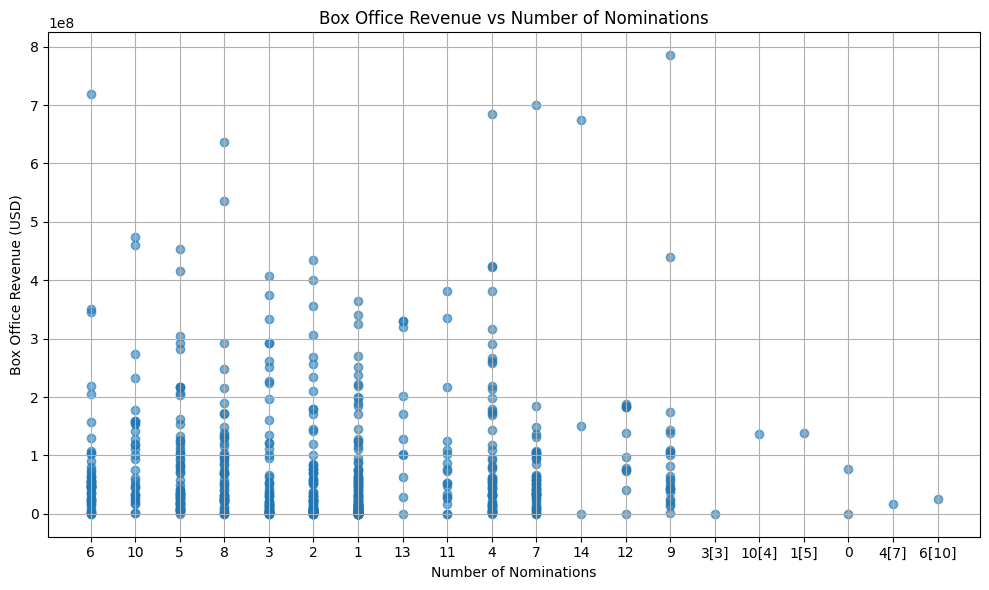

In [63]:
# Box Office Revenue vs Number of Nominations
box_office_vs_nomination = movies.dropna(subset=["BoxOffice", "Nominations"])

plt.figure(figsize=(10, 6))
plt.scatter(box_office_vs_nomination["Nominations"], box_office_vs_nomination["BoxOffice"], alpha=0.6)
plt.title("Box Office Revenue vs Number of Nominations")
plt.xlabel("Number of Nominations")
plt.ylabel("Box Office Revenue (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


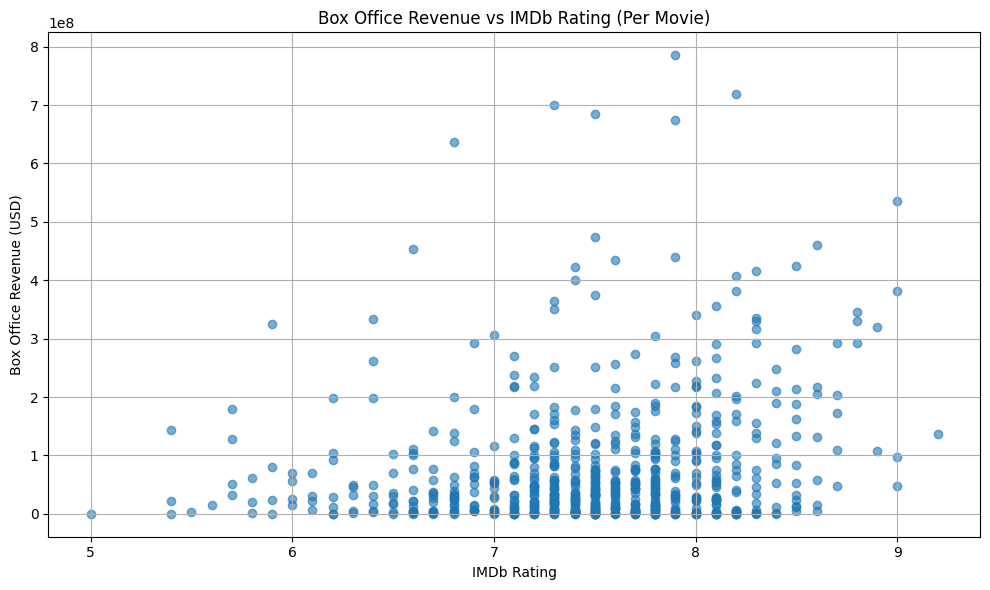

In [ ]:
# Box Office Revenue vs IMDb Rating (Per Movie)
box_office_vs_imdb_rating = movies.dropna(subset=["imdbRating", "BoxOffice"])

plt.figure(figsize=(10, 6))
plt.scatter(scatter_data["imdbRating"], scatter_data["BoxOffice"], alpha=0.6)
plt.title("Box Office Revenue vs IMDb Rating (Per Movie)")
plt.xlabel("IMDb Rating")
plt.ylabel("Box Office Revenue (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

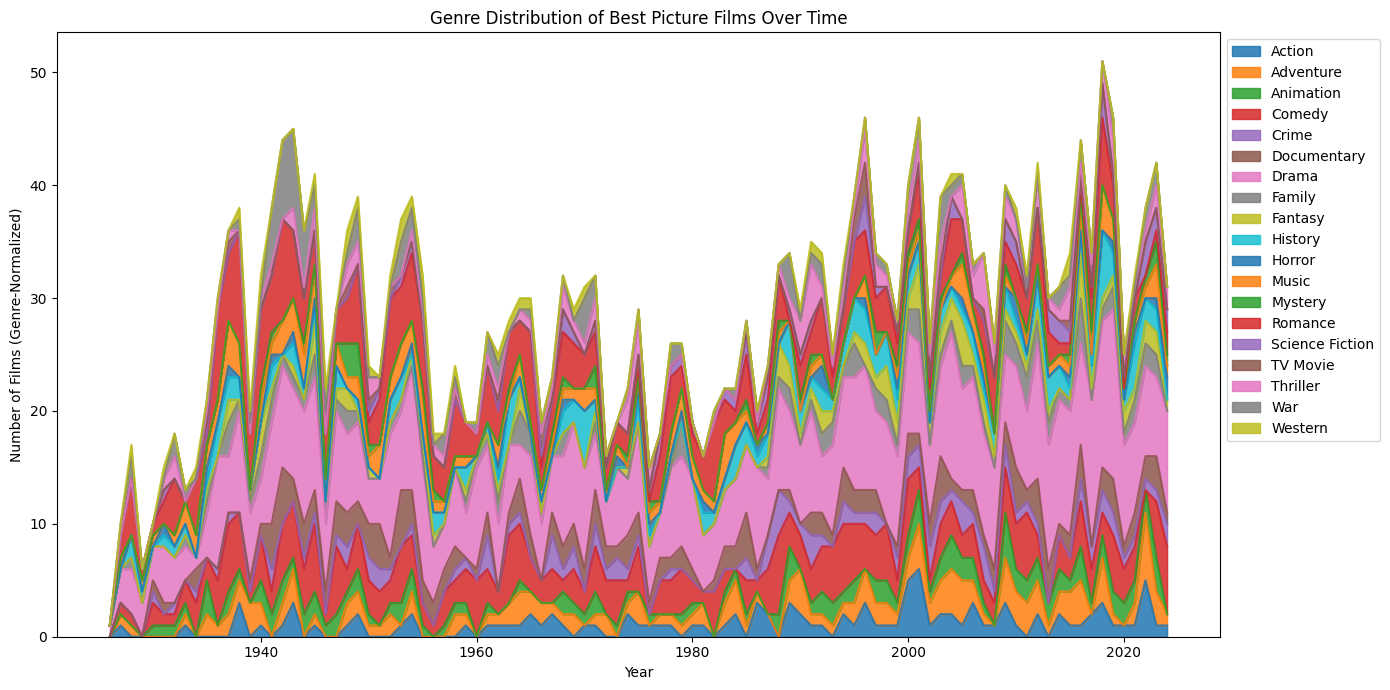

In [57]:
# Genre Distribution of Best Picture Films Over Time
genre_pivot = movie_genres.assign(count=1).pivot_table(
    index="Year", columns="Genre", values="count", aggfunc="sum", fill_value=0
).sort_index()

plt.figure(figsize=(14, 7))
genre_pivot.plot(kind="area", stacked=True, alpha=0.85, figsize=(14, 7))
plt.title("Genre Distribution of Best Picture Films Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Films (Genre-Normalized)")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()


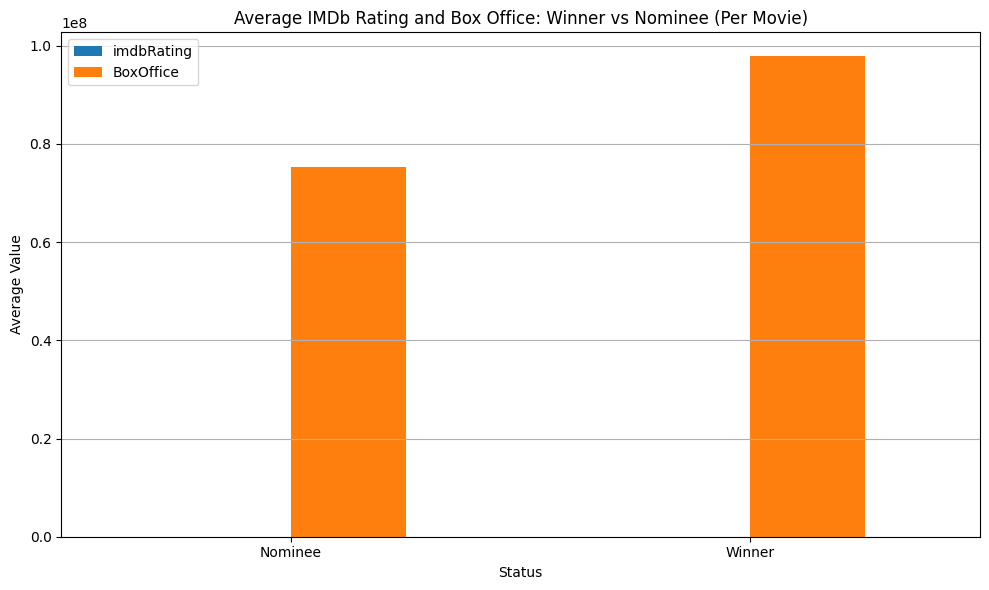

In [58]:
# Average IMDb Rating and Box Office: Winner vs Nominee (Per Movie)
winner_group = movies.groupby("Status")[["imdbRating", "BoxOffice"]].mean().dropna()

winner_group.plot(kind="bar", figsize=(10, 6))
plt.title("Average IMDb Rating and Box Office: Winner vs Nominee (Per Movie)")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


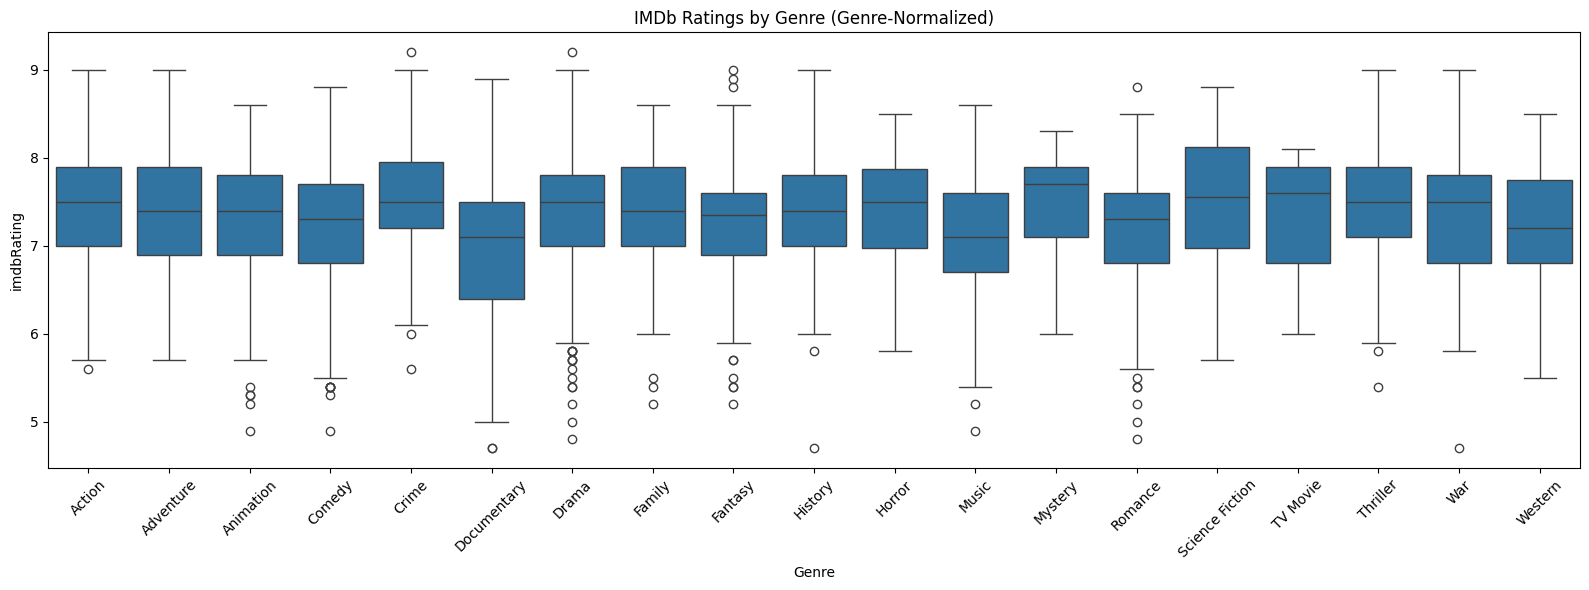

In [59]:
# IMDb Ratings by Genre (Genre-Normalized)
genre_ratings = movie_genres.merge(movies[["Film", "Year", "imdbRating"]], on=["Film", "Year"])
genre_ratings = genre_ratings.dropna(subset=["imdbRating"])

plt.figure(figsize=(16, 6))
sns.boxplot(data=genre_ratings, x="Genre", y="imdbRating")
plt.title("IMDb Ratings by Genre (Genre-Normalized)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


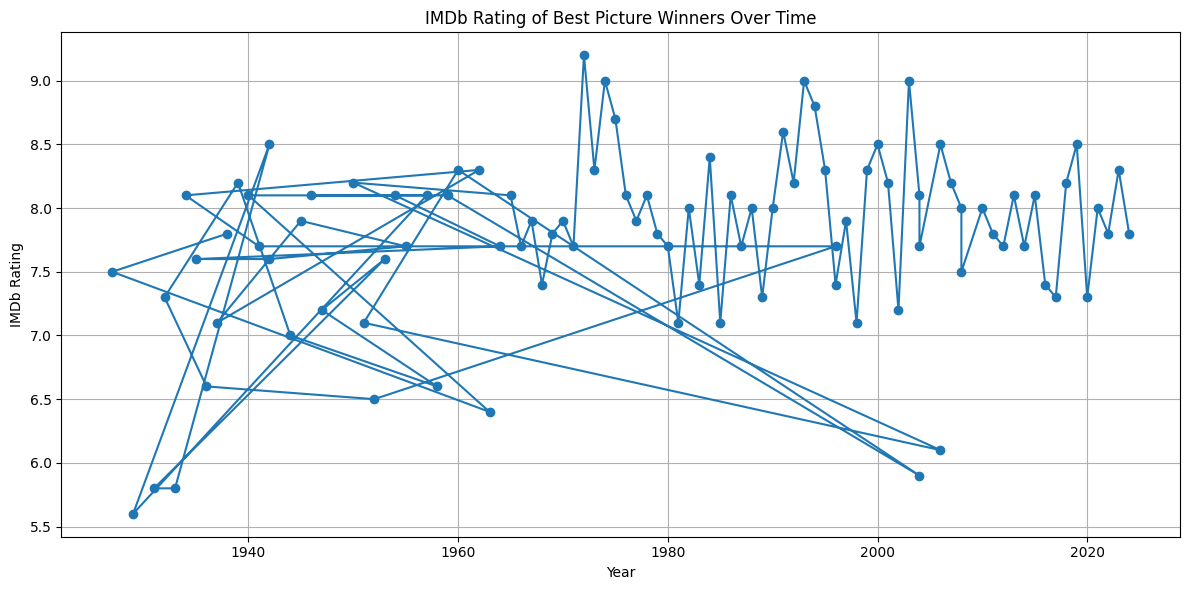

In [ ]:
# IMDb Rating of Best Picture Winners Over Time
winners = movies[movies["Status"] == "Winner"].dropna(subset=["Year", "imdbRating"])

plt.figure(figsize=(12, 6))
plt.plot(winners["Year"], winners["imdbRating"], marker="o", linestyle="-")
plt.title("IMDb Rating of Best Picture Winners Over Time")
plt.xlabel("Year")
plt.ylabel("IMDb Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


## Stretch Goal: Word Cloud (Wikipedia Movie Summaries) ☁️
Placeholder for future development. I plan to create word cloud for the plot summaries. If Wikipedia summaries are accessible, also generate a **word cloud** from commonly used words in movie descriptions.

In [ ]:
# # Sample Wikipedia summary text (replace with actual summaries if available)
# sample_text = "This is a sample summary of a Best Picture-winning film. It tells the story of love, ambition, and success."

# # Tokenize & remove stopwords
# tokens = word_tokenize(sample_text.lower())
# filtered_words = [word for word in tokens if word.isalnum() and word not in stopwords.words("english")]

# # Generate Word Cloud
# wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(filtered_words))

# # Display Word Cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.title("Word Cloud of Wikipedia Movie Summaries")
# plt.show()

In [ ]:
# oscars = pd.read_csv("data/oscars.csv", sep='\t', on_bad_lines='skip')
# oscars = oscars.dropna()
# oscars = oscars.drop_duplicates()
# oscars = oscars.reset_index(drop=True)

In [ ]:
# # Step 4: Store Data in SQLite Database
# conn = sqlite3.connect("academy_awards.db")
# awards_df.to_sql("awards", conn, if_exists="replace", index=False)
# speech_df.to_sql("speeches", conn, if_exists="replace", index=False)

In [ ]:
# # Step 5: SQL Queries & Analysis
# ## Query genres of Best Picture winners over decades
# query = """
# SELECT genre, COUNT(*) AS num_wins, strftime('%Y', award_year) AS decade
# FROM awards
# WHERE category = 'Best Picture'
# GROUP BY genre, decade
# ORDER BY decade ASC;
# """
# genre_trends_df = pd.read_sql(query, conn)

# ## Query word frequency in acceptance speeches
# query = """
# SELECT cleaned_speech FROM speeches;
# """
# speech_texts = pd.read_sql(query, conn)

### Overview of the Analysis (examples)
- In this analysis, we explored the relationship between the race of law enforcement officers and the race of the drivers they stop. Our goal was to see if there’s any indication of bias in traffic stops based on the racial identity of the officers. To do this, we used a chi-squared test for independence, which helps us understand whether there’s a meaningful connection between these two groups.

### Results of the Chi-Squared Test
- **Chi-Squared Statistic:** We calculated a chi-squared statistic of 122.92. This high number shows that there’s a significant difference between the actual number of stops for different racial groups and what we would expect to see if there were no connection between the officer's race and the driver's race. In other words, this suggests that the patterns we observe in the data are unlikely to be just a coincidence.

- **P-Value:** The p-value we found was about 8.20e-17, which is extremely low. This tells us that the result is statistically significant since it’s much lower than the usual thresholds (like 0.05 or 0.01). A low p-value means we have strong evidence against the idea that there’s no connection between the officer's race and the driver's race.

### Interpretation of Findings
- The results show a strong connection between the race of the officer and the race of the driver being stopped. This means that a driver's chances of being stopped may change depending on the officer's race, suggesting there might be some bias in how traffic stops are carried out.

### Implications
- These findings are important for understanding how race plays a role in law enforcement. They suggest that different racial groups might be treated differently by officers during traffic stops. It's crucial to address these biases to ensure fairness and equality in policing.

### Conclusion
- The strong evidence from the chi-squared statistic and p-value emphasizes the importance of further examining law enforcement practices. Police leaders and community advocacy groups should take these findings into account when reviewing policies and training programs designed to reduce racial bias in policing.